In [1]:
from commpy.modulation import QAMModem, PSKModem
from optic.metrics import signal_power, calcLLR, fastBERcalc
from optic.fec import loggaldecode
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from tqdm.notebook import tqdm
from numba import njit
from numba.typed import List

In [2]:
@njit
def awgn(tx, noiseVar):
    
    σ        = np.sqrt(noiseVar)
    noise    = np.random.normal(0,σ, tx.size) + 1j*np.random.normal(0,σ, tx.size)
    noise    = 1/np.sqrt(2)*noise
    
    rx = tx + noise
    
    return rx

def sparse(H):
    
    M, N = H.shape

    Nl = []
    Ml = []
    for m in range(M):
        Nl.append([])

    for n in range(N):
        Ml.append([])

    # Build the sparse representation of A using the M and N sets
    for n in tqdm(range(N)):
        for m in range(M):
            if H[m, n]:
                Nl[m].append(n)
                Ml[n].append(m)
                
    #return Nl, Ml            
    return List(Nl), List(Ml)

## Test LDPC decoding

In [20]:
# A used in chapter
A = np.array([[1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
              [1, 0, 1, 0, 1, 1, 0, 1, 1, 0],
              [0, 0, 1, 1, 1, 0, 1, 0, 1, 1],
              [0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
              [1, 1, 0, 1, 0, 0, 1, 1, 1, 0]])

# Inverse of first part, to get systematic form (not needed for decoding)
Apinv = np.array([[1, 0, 1, 1, 0],
                  [0, 1, 1, 0, 1],
                  [0, 1, 0, 1, 1],
                  [1, 1, 0, 1, 0],
                  [1, 0, 1, 0, 1]])

H = (Apinv@A)%2   # systematic parity check matrix

M, N = A.shape
K = N-M;
P = H[:,N-K:N];
G = np.concatenate((P, np.eye(int(K)))) # now A*G = 0 (mod 2)

m = np.array([[1, 0, 1, 0, 1]]).T
c = (G@m)%2;
t = 2*(2*c-1);

a = 2;   # signal amplitude
sigma2 = 2;  # noise variance

# First set the channel posterior probabilities
p1 = np.array([[.22, .16,  .19,  .48, .55,  .87, .18, .79, .25, .76]]).T

# then compute the received values that correspond to these
r =  np.log((1./p1)-1)/(-2*a)*sigma2;  # received vector

x0 = p1 > 0.5
z0 = (A@x0)%2

Nloop = 50;

Lc = 2*a/sigma2;
Nl, Ml = sparse(H)

#x = galdecode(A,p1,Nloop)
lamb, x = loggaldecode(H, r, Nloop,Lc, Nl, Ml)

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
# Run AWGN simulation 
EbN0dB = 8
M      = 16
Nwords = 1000
Nloop  = 50
Lc = 1

K = H.shape[0]

# generate random bits
bitsTx = np.random.randint(2, size=(K, Nwords)) 
encodedBitsTx = ((G@bitsTx)%2).astype('int')
encodedBitsTx = (encodedBitsTx.T).reshape(1,-1).T

# Map bits to constellation symbols
mod = QAMModem(m=M)
symbTx = mod.modulate(encodedBitsTx)

# Normalize symbols energy to 1
symbTx = symbTx/np.sqrt(mod.Es)

# AWGN    
snrdB    = EbN0dB + 10*np.log10(np.log2(M))
noiseVar = 1/(10**(snrdB/10))

symbRx = awgn(symbTx, noiseVar)

# BER calculation
BER, _, _ = fastBERcalc(symbRx, symbTx, mod)
print('BER = ', BER[0])

constSymb = mod.constellation
bitMap = mod.demodulate(constSymb, demod_type="hard")
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = mod.Es

llr = calcLLR(symbRx, noiseVar, constSymb / np.sqrt(Es), bitMap)
llr = llr.reshape(-1,1)

decBits = np.zeros((10*Nwords,1))
decBits[:] = np.nan

for k in range(Nwords):  
    llr_in = llr[10*k:10*k+10, :]
    llr_out,_ = loggaldecode(H, llr_in, Nloop, Lc, Nl, Ml)
    decBits[10*k:10*k+10,:] = ( np.sign(-llr_out) + 1 )/2

BERpost = np.mean(np.logical_xor(encodedBitsTx, decBits))

print('BERpostFEC = ', BERpost)

BER =  0.0109
BERpostFEC =  0.0007


## Test AR4JA LDPC 

In [74]:
path = r'C:\Users\edson\Documents\GitHub\edsonportosilva\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'

d = sp.io.loadmat(path+'\LDPC_11nD2_1944b_R12.mat')
H = d['LDPC']['H'] # parity check matrix
H = H[0][0][0][0][0]
H = H.astype(np.int32)

In [75]:
M, N = H.shape
K = N-M
P = H[:,N-K:N]
G = np.concatenate((P, np.eye(int(K)))) # now A*G = 0 (mod 2)

In [79]:
# Run AWGN simulation 
EbN0dB = 20
M      = 4
Nwords = 8
Nloop  = 10
Lc = 1

# generate random bits
bitsTx = np.random.randint(2, size=(K, Nwords)) 
encodedBitsTx = ((G@bitsTx)%2).astype('int')
encodedBitsTx = (encodedBitsTx.T).reshape(1,-1).T

# Map bits to constellation symbols
mod = QAMModem(m=M)
symbTx = mod.modulate(encodedBitsTx)

# Normalize symbols energy to 1
symbTx = symbTx/np.sqrt(mod.Es)

# AWGN    
snrdB    = EbN0dB + 10*np.log10(np.log2(M))
noiseVar = 1/(10**(snrdB/10))

symbRx = awgn(symbTx, noiseVar)

# BER calculation
BER, _, _ = fastBERcalc(symbRx, symbTx, mod)
print('BER = ', BER[0])

constSymb = mod.constellation
bitMap = mod.demodulate(constSymb, demod_type="hard")
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = mod.Es

llr = calcLLR(symbRx, noiseVar, constSymb / np.sqrt(Es), bitMap)
llr = llr.reshape(-1,1)

decBits = np.zeros((N*Nwords,1))
decBits[:] = np.nan

Nl, Ml = sparse(H)

BER =  0.0


  0%|          | 0/1944 [00:00<?, ?it/s]

In [80]:
for ii in range(Nwords):  
    llr_in = llr[N*ii:N*ii+N, :]
    llr_out,_ = loggaldecode(H, llr_in, Nloop, Lc, Nl, Ml)
    decBits[N*ii:N*ii+N,:] = ( np.sign(-llr_out) + 1 )/2

BERpost = np.mean(np.logical_xor(encodedBitsTx, decBits))

print('BERpostFEC = ', BERpost)

BERpostFEC =  0.03825874485596708


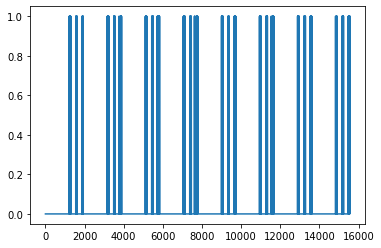

In [81]:
plt.plot(np.logical_xor(encodedBitsTx, decBits))